# Setting Up

In [143]:
from config.constants import *
from config.utils import *

df = DATA_INPUTS['main_dataset']

if len(df) != 0:
    logger.info(f'Dataframe imported successfully with a length of {len(df)} 🎉')

2023-08-21 12:20:34.099 | INFO     | __main__:<module>:7 - Dataframe imported successfully with a length of 10000 🎉


In [144]:
print(f'There are {len(df.columns)} columns: {list(df.columns)}.')

There are 10 columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date', 'tokens', 'refined_text', 'vector', 'le_category'].


In [145]:
categories = df.category.unique()
print(f'There are {len(categories)} columns:\n')

half = len(categories) // 2
left_col = categories[:half]
right_col = categories[half:]

for left, right in zip(left_col, right_col):
    print(f'{left: <25}{right}')

There are 12 columns:

ENTERTAINMENT            BUSINESS
COMEDY                   SCIENCE
QUEER VOICES             WORLD NEWS
TECH                     EDUCATION
WELLNESS                 MONEY
BLACK VOICES             ARTS & CULTURE


In [146]:
df.category.value_counts()

category
WELLNESS          2535
ENTERTAINMENT     2463
QUEER VOICES       959
BUSINESS           853
COMEDY             798
BLACK VOICES       686
WORLD NEWS         496
TECH               311
SCIENCE            310
MONEY              253
ARTS & CULTURE     190
EDUCATION          146
Name: count, dtype: int64

# Tokenizer

In [147]:
def tokenizer(text: str, stopwords: set = STOPWORDS, punctuations: set = PUNCTUATIONS) -> tuple[list, str]:
    emojis = demoji.findall(text)
    
    new_text = ''
    for character in text:
        if character in emojis.keys():
            new_text += str.join('_', str.split(emojis[character])) + ' '
        else:
            new_text += character
    
    lemmatizer = WordNetLemmatizer()
    lemmas = [ lemmatizer.lemmatize(word) for word in word_tokenize(new_text) ]
    tokens = [ str.lower(token) for token in lemmas if token not in stopwords and token not in punctuations ]
    
    refined_text = str.join(' ', tokens)
    
    if len(tokens) == 0:
        return ['NULL'], 'NULL'
    else:
        return tokens, refined_text

In [148]:
df['tokens'], df['refined_text'] = df.headline.apply(lambda x: tokenizer(x, STOPWORDS, PUNCTUATIONS)[0]), df.headline.apply(lambda y: tokenizer(y, STOPWORDS, PUNCTUATIONS)[-1])

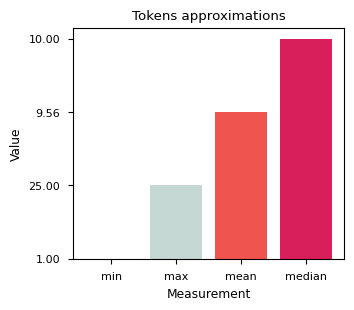

In [149]:
def token_approximation(text: str) -> int:
  return len(str.split(text))

ta = dict({
  'min': f'{np.min([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'max': f'{np.max([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'mean': f'{np.mean([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'median': f'{np.median([token_approximation(text) for text in df.refined_text.tolist()]):.2f}'
})

token_approximations = pd.DataFrame(list(ta.items()), columns=['measurement', 'value'])

plt.figure(figsize=(3.5, 3))
plt.style.use('seaborn-v0_8-paper')

plt.bar(token_approximations.measurement, token_approximations.value, color=['#fdf0d5', '#c6d8d3', '#f0544f', '#d81e5b'])
plt.title('Tokens approximations')
plt.xlabel('Measurement')
plt.ylabel('Value')
plt.show()

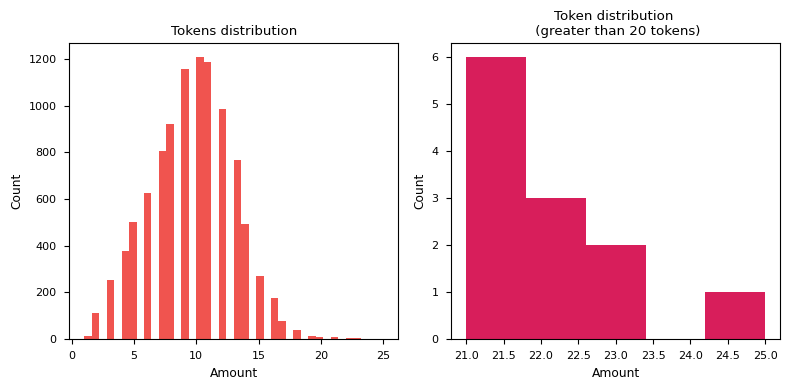

In [150]:
aux = df.copy(deep=True)
aux['tl'] = aux.tokens.apply(lambda x: len(x))
aux = aux.tl.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(aux, bins=40, color='#f0544f')
ax1.set_title('Tokens distribution')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Count')

aux2 = df.copy(deep=True)
aux2['tl'] = aux2.tokens.apply(lambda x: len(x))
aux2 = aux2.query('tl > 20')
aux2 = aux2.tl.tolist()

ax2.hist(aux2, bins=5, color='#d81e5b')
ax2.set_title('Token distribution \n (greater than 20 tokens)')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()


# Vectorizer

In [151]:
vocab = list()
for tokens in df.tokens:
    vocab.extend(tokens)

vocab = set(vocab)
vocab = dict(zip(vocab, range(2, len(vocab) + 2)))
vocab['UNK'] = 1
vocab['PAD'] = 0
vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))

In [152]:
def get_ids(text: str, max_length: int) -> np.ndarray[int]:
  text = str.lower(text)
  vector = [vocab[word] if word in vocab.keys() else vocab['UNK'] for word in text.split()]
  vector = vector[:max_length] + [vocab['PAD']] * (max_length - len(vector))
  return np.array(vector)

def get_attention_mask(ids: np.ndarray[int]) -> np.ndarray[int]:
  return np.array([1 if id > 0 else 0 for id in ids])

def ids_decoder(ids: np.ndarray[int], vocab: dict[str, int]) -> str:
  reconstruction = list(vocab.keys())[list(vocab.values()).index(ids[0])]
  for i in ids[1:]:
      word = list(vocab.keys())[list(vocab.values()).index(i)]
      word = ' ' + word if word != 'PAD' else ''
      reconstruction += word
      
  return reconstruction

max_length = 32
sample_text = df.sample(1, random_state=26).refined_text.values[0]
input_ids = get_ids(sample_text, max_length)
attention_mask = get_attention_mask(input_ids)

input_ids, attention_mask

(array([10804,  4849, 12825,  2127,  6170,  9823,   616, 14837,  5054,
        11890,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [153]:
df['vector'] = df.refined_text.apply(lambda x: get_ids(text=x, max_length=32))

In [154]:
df.sample(10)

,link,headline,category,short_description,authors,date,tokens,refined_text,vector,le_category
16107,https://www.huffingtonpost.com/entry/taiwan-th...,Taiwan Is Considering Third Gender Option For ...,QUEER VOICES,LGBTQ activists say the change would showcase ...,"Beh Lih Yi, Reuters",2018-01-17,"[taiwan, is, considering, third, gender, optio...",taiwan is considering third gender option for ...,"[11122, 6143, 6764, 11417, 308, 14290, 1027, 1...",7
184763,https://www.huffingtonpost.com/entry/mindful-e...,Say 'No' to Too Much Food,WELLNESS,"With the holiday season coming, many people gi...","Helene Lerner, Contributor\nCEO, Creative Expa...",2012-10-20,"[say, 'no, too, much, food]",say 'no too much food,"[7797, 10864, 7854, 12235, 14742, 0, 0, 0, 0, ...",10
74650,https://www.huffingtonpost.com/entry/rob-thoma...,Matchbox 20 Singer Rob Thomas Apologizes For R...,ENTERTAINMENT,"""I am truly sorry for how this came across, mo...",Carly Ledbetter,2016-02-22,"[matchbox, 20, singer, rob, thomas, apologizes...",matchbox 20 singer rob thomas apologizes for r...,"[2764, 6762, 9431, 12721, 8566, 7193, 1027, 10...",5
92982,https://www.huffingtonpost.comhttp://fusion.ne...,Transgender Army Sergeant Shane Ortega Opens U...,QUEER VOICES,Secretary of Defense Ash Carter has said we’ve...,,2015-07-30,"[transgender, army, sergeant, shane, ortega, o...",transgender army sergeant shane ortega opens u...,"[14063, 10599, 6745, 6947, 1025, 933, 1846, 35...",7
78643,https://www.huffingtonpost.com/entry/dinosaurs...,Dinosaurs May Have Danced Like Lovebirds To Wo...,SCIENCE,Newly discovered footprints and scrape marks m...,"Malcolm Ritter, Associated Press",2016-01-08,"[dinosaurs, may, have, danced, like, lovebirds...",dinosaurs may have danced like lovebirds to wo...,"[10950, 3844, 9785, 1049, 4497, 7317, 3591, 88...",8
43588,https://www.huffingtonpost.com/entry/marc-truj...,Marc Trujillo: 'Nowhere And Everywhere',ARTS & CULTURE,What are you interested in outside of painting...,"John Seed, ContributorProfessor of Art History",2017-02-09,"[marc, trujillo, 'nowhere, and, everywhere]",marc trujillo 'nowhere and everywhere,"[14027, 5977, 6345, 10490, 11133, 0, 0, 0, 0, ...",0
200054,https://www.huffingtonpost.comhttp://www.theda...,Hoarding Made A Hit TV Show -- Now It's Becomi...,WELLNESS,The newest edition of the Diagnostic and Stati...,,2012-05-09,"[hoarding, made, a, hit, tv, show, --, now, it...",hoarding made a hit tv show -- now it 's becom...,"[2791, 11541, 5931, 6854, 12629, 14169, 6797, ...",10
178757,https://www.huffingtonpost.com/entry/christmas...,GPS Guide: Bright Christmas Lights To Get You ...,WELLNESS,'Twas the eve before Christmas and all through...,,2012-12-24,"[gps, guide, bright, christmas, lights, to, ge...",gps guide bright christmas lights to get you i...,"[7475, 9078, 7758, 12772, 9521, 3591, 15193, 3...",10
12495,https://www.huffingtonpost.com/entry/seth-meye...,Seth Meyers: Donald Trump Just Spoke ‘The True...,COMEDY,"The comedian also likened the White House to ""...",Lee Moran,2018-03-16,"[seth, meyers, donald, trump, just, spoke, ‘, ...",seth meyers donald trump just spoke ‘ the true...,"[1023, 6315, 10466, 3112, 12410, 13947, 4507, ...",3
32218,https://www.huffingtonpost.com/entry/brexit-ta...,"On Day One Of The Brexit Talks, EU Reminds Bri...",WORLD NEWS,“I am neither optimistic nor pessimistic. I am...,,2017-06-19,"[on, day, one, of, the, brexit, talks, eu, rem...",on day one of the brexit talks eu reminds brit...,"[5054, 13975, 69, 5335, 14326, 13942, 8504, 94...",11


# Label Encoding

In [155]:
le = LabelEncoder()
le.fit(df.category.tolist())
le.classes_

array(['ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COMEDY',
       'EDUCATION', 'ENTERTAINMENT', 'MONEY', 'QUEER VOICES', 'SCIENCE',
       'TECH', 'WELLNESS', 'WORLD NEWS'], dtype='<U14')

In [156]:
joblib.dump(value=le, filename='../assets/artifacts/label_encoder.pkl', compress=True)

['../assets/artifacts/label_encoder.pkl']

In [157]:
df['le_category'] = le.transform(df.category)

In [158]:
df.sample(5)

,link,headline,category,short_description,authors,date,tokens,refined_text,vector,le_category
33344,https://www.huffingtonpost.com/entry/londoner-...,Wounded Londoner Recalls Charging At Armed Ter...,WORLD NEWS,"Roy Larner's friends gave him a manual, ""Learn...",Nina Golgowski,2017-06-06,"[wounded, londoner, recalls, charging, at, arm...",wounded londoner recalls charging at armed ter...,"[14374, 3515, 5064, 12101, 2895, 10867, 1163, ...",11
135959,https://www.huffingtonpost.com/entry/how-kindn...,How Kindness Will Change Your Life and the World,WELLNESS,What is the point of being kind to a stranger ...,"Tina Williamson, Contributor\nStudent of Buddh...",2014-03-24,"[how, kindness, will, change, your, life, world]",how kindness will change your life world,"[14446, 9581, 1527, 2677, 11907, 15852, 10810,...",10
93477,https://www.huffingtonpost.com/entry/dwayne-th...,The Rock's 'Baywatch' Film Is Almost A Reality,ENTERTAINMENT,"""Cue slo mo running on the beach.""",Dominique Mosbergen,2015-07-24,"[the, rock, 's, 'baywatch, film, is, almost, a...",the rock 's 'baywatch film is almost a reality,"[14326, 8936, 5052, 9241, 7092, 6143, 7759, 59...",5
160544,https://www.huffingtonpost.com/entry/bed-bath-...,Bed Bath And Beyond Fire Caught On Tape By Cus...,BUSINESS,"""It was kinda just running up the wall and the...",,2013-07-05,"[bed, bath, and, beyond, fire, caught, on, tap...",bed bath and beyond fire caught on tape by cus...,"[15061, 13295, 10490, 8964, 3196, 7994, 5054, ...",2
166033,https://www.huffingtonpost.com/entry/nails-tel...,7 Things Your Nails Can Tell You About Your He...,WELLNESS,By Jene Luciani for Shape.com You spend so muc...,,2013-05-08,"[7, things, your, nails, can, tell, you, about...",7 things your nails can tell you about your he...,"[14456, 3659, 11907, 131, 11694, 14049, 318, 3...",10


# Getting the whole vocabulary

In [159]:
df = pd.read_json('../assets/data/news_dataset.json', lines=True)

if len(df) != 0:
    logger.info(f'Dataframe imported successfully with a length of {len(df)} 🎉')

2023-08-21 12:21:35.566 | INFO     | __main__:<module>:4 - Dataframe imported successfully with a length of 209527 🎉


In [161]:
df['tokens'], df['refined_text'] = df.headline.apply(lambda x: tokenizer(x, STOPWORDS, PUNCTUATIONS)[0]), df.headline.apply(lambda y: tokenizer(y, STOPWORDS, PUNCTUATIONS)[-1])

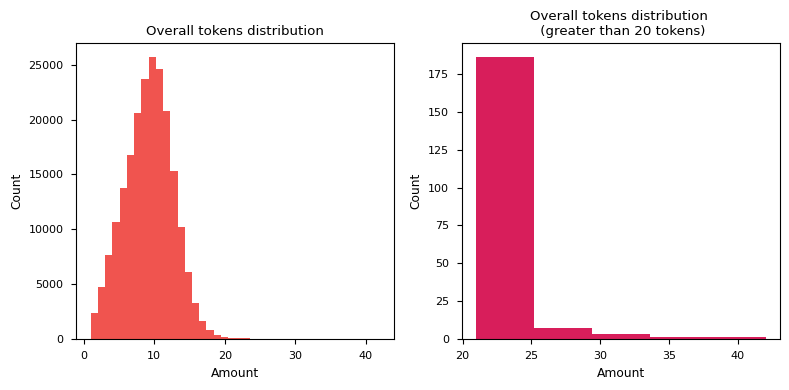

In [162]:
aux = df.copy(deep=True)
aux['tl'] = aux.tokens.apply(lambda x: len(x))
aux = aux.tl.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(aux, bins=40, color='#f0544f')
ax1.set_title('Overall tokens distribution')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Count')

aux2 = df.copy(deep=True)
aux2['tl'] = aux2.tokens.apply(lambda x: len(x))
aux2 = aux2.query('tl > 20')
aux2 = aux2.tl.tolist()

ax2.hist(aux2, bins=5, color='#d81e5b')
ax2.set_title('Overall tokens distribution \n (greater than 20 tokens)')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [163]:
vocab = list()
for tokens in df.tokens:
    vocab.extend(tokens)

vocab = set(vocab)
vocab = dict(zip(vocab, range(2, len(vocab) + 2)))
vocab['UNK'] = 1
vocab['PAD'] = 0
vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))

In [183]:
joblib.dump(value=vocab, filename='../assets/artifacts/vocab.pkl', compress=True)

['../assets/artifacts/vocab.pkl']